# Do some imports

In [1]:
import numpy as np
import pandas as pd
#!pip install --user pandas

import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F

from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from dataloader import UNSW_NB15

### Inspired by [this github file](https://github.com/alik604/cyber-security/blob/master/Intrusion-Detection/UNSW_NB15%20-%20Torch%20MLP%20and%20autoEncoder.ipynb)

# Get UNSW_NB15 train and test set

In [2]:
#!wget https://www.unsw.adfa.edu.au/unsw-canberra-cyber/cybersecurity/ADFA-NB15-Datasets/a%20part%20of%20training%20and%20testing%20set/UNSW_NB15_training-set.csv

In [3]:
#!wget https://www.unsw.adfa.edu.au/unsw-canberra-cyber/cybersecurity/ADFA-NB15-Datasets/a%20part%20of%20training%20and%20testing%20set/UNSW_NB15_testing-set.csv

# Define the Neural Network class

In [4]:
# define NN architecture
class Net(nn.Module):
    
    def __init__(self, input_size,hidden1, hidden2, hidden3, num_classes):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden1)
        self.batchnorm1 = nn.BatchNorm1d(hidden1)
        self.relu1 = nn.ReLU()
        self.dout = nn.Dropout(0.5)
        
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.batchnorm2 = nn.BatchNorm1d(hidden2)
        self.relu2 = nn.ReLU()

        
        self.fc3 = nn.Linear(hidden2, hidden3)
        self.batchnorm3 = nn.BatchNorm1d(hidden3)
        self.relu3 = nn.ReLU()

        
        self.out = nn.Linear(hidden3, num_classes)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        a1 = self.fc1(x)
        #b1 = self.batchnorm1(a1)
        h1 = self.relu1(a1)
        dout1 = self.dout(h1)
        
        a2 = self.fc2(dout1)
        #b2 = self.batchnorm2(a2)
        h2 = self.relu2(a2)
        dout2 = self.dout(h2)
        
        a3 = self.fc3(dout2)
        #b3 = self.batchnorm3(a3)
        h3 = self.relu3(a3)
        dout3 = self.dout(h3)
        
        a4= self.out(dout3)
        y = self.sigmoid(a4)
        return y

### Define Train,   Test   and    Display_Loss_Plot    methods

In [5]:
def train(model, device, train_loader, optimizer, criterion):
    losses = []
    model.train()
    y_true = []
    y_pred = []
    
    for i, data in enumerate(train_loader, 0):
        
        # get the inputs; data is a list of [inputs, target ( or labels)]
        inputs , target = data
        
        optimizer.zero_grad()
        
        #MOVING THE TENSORS TO THE CONFIGURED DEVICE
        #inputs, target = inputs.to(device), target.to(device)
        
        #FORWARD PASS
        output = model(inputs.float())

        loss = criterion(output, target.unsqueeze(1))
        #import pdb; pdb.set_trace()
        
        #BACKWARD AND OPTIMIZE
        
        loss.backward()
        optimizer.step()
        
        # PREDICTIONS
        #pred = np.round(output.detach().numpy())
        pred = output.detach().numpy() > 0.5  
        target = target.float()
        y_true.extend(target.tolist()) 
        y_pred.extend(pred.reshape(-1).tolist())
        
        losses.append(loss.data.numpy()) 
    #print("Accuracy on training set is" , accuracy_score(y_true,y_pred))
    return losses

In [6]:
#TESTING THE MODEL
def test(model, device, test_loader):
    #model in eval mode skips Dropout etc
    model.eval()
    y_true = []
    y_pred = []
    
    # set the requires_grad flag to false as we are in the test mode
    with torch.no_grad():
        for data in test_loader:
            
            #LOAD THE DATA IN A BATCH
            inputs ,target = data
            
            # the model on the data
            output = model(inputs.float())
                       
            #PREDICTIONS
            pred = np.round(output)
            #pred = output.detach().numpy() > 0.5 
            pred = pred * 1
            target = target.float()
            y_true.extend(target.tolist()) 
            y_pred.extend(pred.reshape(-1).tolist())
        
    return accuracy_score(y_true, y_pred)

In [7]:
def display_loss_plot(losses):
    x_axis = [i for i in range(len(losses))]
    plt.plot(x_axis,losses)
    plt.title('Loss of the model')
    plt.xlabel('iterations')
    plt.ylabel('Cross entropy loss')
    plt.show()

# Define some parameters first

In [8]:
device = 'cpu'
input_size = 196      # 42 for integer encoding 196
hidden1 = 128      # 1st layer number of neurons
hidden2 = 64
hidden3 = 32
num_classes = 1    # binary classification

num_epochs = 200
batch_size = 8000 
lr = 0.001

# Initialize Neural Network class

In [9]:
model = Net(input_size, hidden1, hidden2, hidden3, num_classes)

# Define loss and optimizer 

In [10]:
criterion = nn.BCELoss()
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999))

# Initialize UNSW_NB15 class

In [11]:
#these are not slitted into validation and train set
train_dataset = UNSW_NB15(file_path ='UNSW_NB15_training-set.csv')
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

#get the test dataframe
test_dataset = UNSW_NB15(file_path ='UNSW_NB15_testing-set.csv')
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


torch.Size([175341, 197])
torch.Size([82332, 197])


# Lets Train, Test the model and see the loss

In [12]:
running_loss = []
for epoch in tqdm(range(num_epochs)):
        loss_epoch = train(model, device, train_loader, optimizer,criterion)
        running_loss.append(loss_epoch)

In [13]:
test(model,device,test_loader)

0.7572389836272653

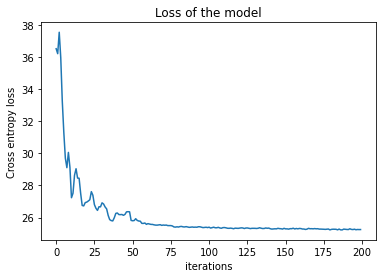

In [14]:
loss_per_epoch = [np.mean(loss_per_epoch) for loss_per_epoch in running_loss]
display_loss_plot(loss_per_epoch)

**********************************************************************************************************************

# Results

    num_epochs = 100
    batch_size = 500 
    lr = 0.1
    accuracy on test set = 0.5506

    num_epochs = 100
    batch_size = 100 
    lr = 0.005 
     accuracy on test set = 0.5506